In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import l1_min_c
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import statsmodels
import math
from sklearn.preprocessing import MinMaxScaler
from statsmodels.formula.api import ols
warnings.filterwarnings("ignore")

In [139]:
input_file_path = "../data/"

In [140]:
data = pd.read_csv(input_file_path+"ps2_public.csv")

# Preprocessing & Exploration

## Deal with na values and create dummy variables for categorical data

In [141]:
## the ratio between treatment 0 and 1 looks fine --> not much skewed
data["treatment"].value_counts()

1    4144
0    3356
Name: treatment, dtype: int64

In [142]:
### na values only exist in Family History column
## as the proportion of rows with nan value in family history column was not small, I decided to let it as a value of feature.
for i in data.columns:
    print(len(data[data[i].isnull()==True]))

0
0
0
0
0
2607
0
0
0
0
0
0


In [143]:
2607/7500

0.3476

In [144]:
data["family_history"].value_counts()

False    4824
True       69
Name: family_history, dtype: int64

In [145]:
### Family history False --> -1, True --> 1, nan --> 0
data = data.fillna(100)
def family_history(x):
    if x == False:
        return -1
    if x == True:
        return 1
    if x == 100:
        return 0
    else:
        print("error")
data["family_history"] = data["family_history"].apply(lambda x: family_history(x))

In [146]:
## Male --> 1, Female --> 0
def gender(x):
    if x == "non-female":
        return 1
    if x == "female":
        return 0
    else:
        print("error")
data["gender"] = data["gender"].apply(lambda x: gender(x))

In [147]:
## Blood_test positive --> 1, negative --> 0
def blood_test(x):
    if x == "negative":
        return 0
    if x == "positive":
        return 1
    else:
        print("error")
data["blood_test"] = data["blood_test"].apply(lambda x: blood_test(x))

In [148]:
## GeneC not active--> 0, active --> 1
def GeneC(x):
    if x == "not active":
        return 0
    if x == "active":
        return 1
    else:
        print("error")
data["GeneC"] = data["GeneC"].apply(lambda x: GeneC(x))

In [149]:
print(data.age.max())
print(data.age.min())

93
29


# age

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba24fe3f10>,
      dtype=object)

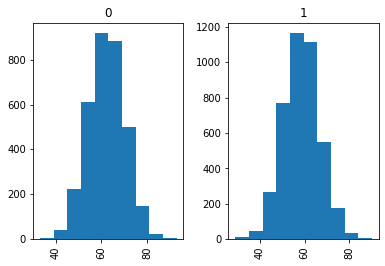

In [150]:
### histogram of age groupby treatment
data.age.hist(by=data.treatment)

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: age, dtype: object

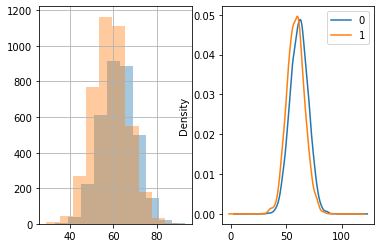

In [151]:
### histogram of age groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").age.plot(kind='kde', ax=axs[1], legend = True)
data.groupby("treatment").age.hist(alpha=0.4, ax=axs[0])

#https://stackoverflow.com/questions/21548750/plotting-histograms-against-classes-in-pandas-matplotlib

In [152]:
pval_list = []
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["age"],data[data["treatment"]==1]["age"],alternative="two-sided",usevar="unequal")
pval_list.append(("age", pval))
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

# Blood_Pressure

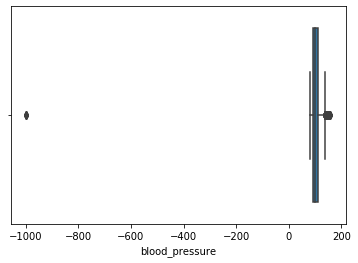

In [153]:
#### remove outliers!
sns.boxplot(x=data["blood_pressure"])

In [154]:
## -999 seems to be nan value
data[data["blood_pressure"]<0]

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
379,1,52,-999.0,0,0,-1,-0.367084,-0.125044,1,1,0,0
1539,1,59,-999.0,0,0,-1,4.776677,-0.088575,0,0,0,1
1685,1,65,-999.0,0,0,-1,4.026843,-0.122242,1,0,0,1
2123,1,51,-999.0,0,0,0,0.677114,0.047250,1,1,1,1
5773,1,68,-999.0,0,0,-1,8.524262,-0.244947,0,1,0,1
6301,0,46,-999.0,1,0,-1,-1.834005,-0.265692,0,0,1,0
6502,1,58,-999.0,0,1,-1,3.480871,0.022472,0,1,1,1


In [155]:
## Split Train, Test data
## allocate predictors to X
X = data.iloc[:,1:]

## allocate test value to y
y = data["treatment"]

## Train, validation, test split applying random state
## Train : Validation : Test = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

In [162]:
# change -999 blood_pressure to mean value of train set
mean_blood_pressure = X_train[X_train.blood_pressure != -999].blood_pressure.mean()
data["blood_pressure"] = data["blood_pressure"].replace(-999,mean_blood_pressure)
mean_blood_pressure


102.14176448747929

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: blood_pressure, dtype: object

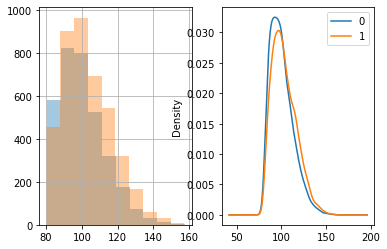

In [163]:
### histogram of age groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").blood_pressure.plot(kind='kde', ax=axs[1], legend = True)
data.groupby("treatment").blood_pressure.hist(alpha=0.4, ax=axs[0])

#https://stackoverflow.com/questions/21548750/plotting-histograms-against-classes-in-pandas-matplotlib

In [164]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["blood_pressure"],data[data["treatment"]==1]["blood_pressure"],alternative="two-sided",usevar="unequal")
pval_list.append(("blood_pressure", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  8.566937971827714e-23


# gender

In [165]:
def stacked_barplot_btw_columns(data, col1, col2, label1, label2):##col1 : target

## count numbers
    count_gender = data[[col1,col2]].groupby([col1,col2]).size()

    male_0 = count_gender[0,1]
    male_1 = count_gender[1,1]
    female_0 = count_gender[0,0]
    female_1 = count_gender[1,0]

    treatment_1 = [male_1, female_1]
    treatment_0 = [male_0, female_0]
    width = 0.5

    p1 = plt.bar([label1, label2],[male_0,female_0])
    p2 = plt.bar([label1, label2],[male_1,female_1], bottom = [male_0,female_0])

    plt.ylabel('Count by treatment')
    plt.xlabel(col2)
    plt.legend((p1[0], p2[0]), ('Treatment 0', 'Treatment 1'))

    plt.show()

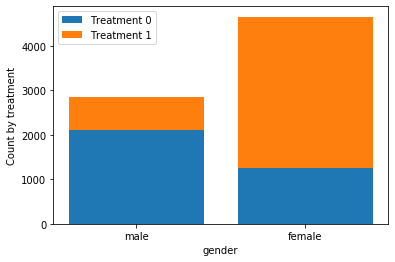

In [166]:
stacked_barplot_btw_columns(data, "treatment", "gender", "male", "female")

### Female had higher proportion of Treatment 1

In [167]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["gender"],data[data["treatment"]==1]["gender"],alternative="two-sided",usevar="unequal")
pval_list.append(("gender", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.0


# Blood_test

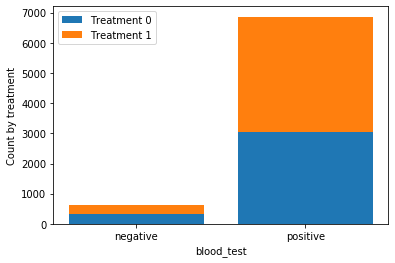

In [168]:
stacked_barplot_btw_columns(data, "treatment", "blood_test", "negative", "positive")

In [169]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["blood_test"],data[data["treatment"]==1]["blood_test"],alternative="two-sided",usevar="unequal")
pval_list.append(("blood_test", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.016763878878604723


# Family_History

In [170]:
count_family_history = data[["treatment", "family_history"]].groupby(["treatment", "family_history"]).size()

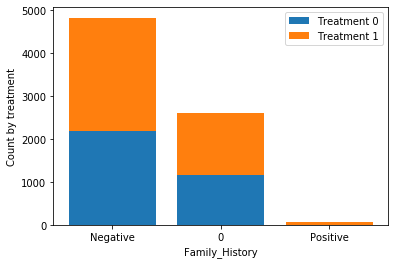

In [171]:
neg_0 = count_family_history [0,-1]
nan_0 = count_family_history [0,0]
pos_0 = count_family_history [0,1]
neg_1 = count_family_history [1,-1]
nan_1 = count_family_history [1,0]
pos_1 = count_family_history [1,1]


treatment_1 = [neg_1, nan_1, pos_1]
treatment_0 = [neg_0, nan_0, pos_0]
width = 0.5

p1 = plt.bar(["Negative", "0", "Positive"], treatment_0)
p2 = plt.bar(["Negative", "0", "Positive"], treatment_1, bottom = treatment_0)

plt.ylabel('Count by treatment')
plt.xlabel("Family_History")
plt.legend((p1[0], p2[0]), ('Treatment 0', 'Treatment 1'))

plt.show()

In [172]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["family_history"],data[data["treatment"]==1]["family_history"],alternative="two-sided",usevar="unequal")
pval_list.append(("Family_History", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.008474968788835285


# TestA

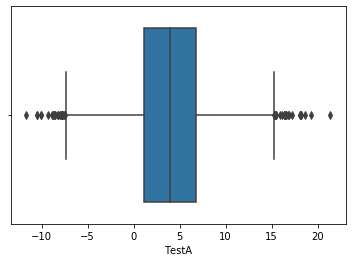

In [173]:
## Box plot
sns.boxplot(x=data["TestA"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba25dc2bd0>,
      dtype=object)

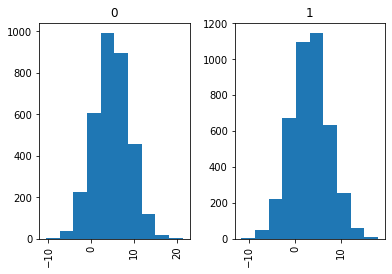

In [174]:
### histogram of TestA groupby treatment
data.TestA.hist(by=data.treatment)

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: TestA, dtype: object

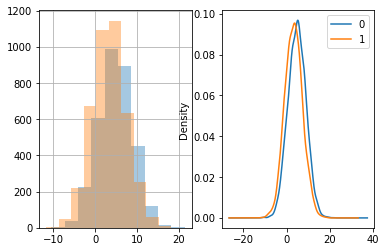

In [175]:
### histogram of TestA groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").TestA.plot(kind='kde', ax=axs[1], legend =True)
data.groupby("treatment").TestA.hist(alpha=0.4, ax=axs[0])

In [176]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["TestA"],data[data["treatment"]==1]["TestA"],alternative="two-sided",usevar="unequal")
pval_list.append(("TestA", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  3.371280032526245e-59


# TestB

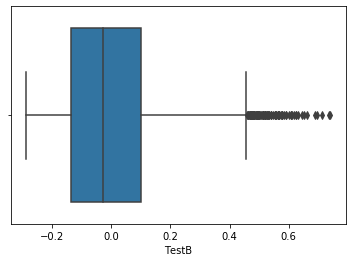

In [177]:
## Boxplot
sns.boxplot(x=data["TestB"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba26016510>,
      dtype=object)

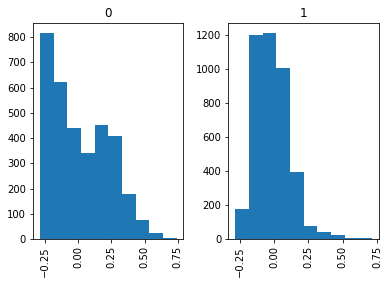

In [178]:
### histogram of TestB groupby treatment
data.TestB.hist(by=data.treatment)

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: TestB, dtype: object

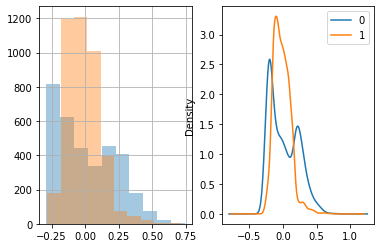

In [179]:
### histogram of TestB groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").TestB.plot(kind='kde', ax=axs[1], legend = True)
data.groupby("treatment").TestB.hist(alpha=0.4, ax=axs[0])

In [180]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["TestB"],data[data["treatment"]==1]["TestB"],alternative="two-sided",usevar="unequal")
# pval_list.append(("TestB", pval))
print("P-value : ",pval)

P-value :  2.564103416101554e-12


In [181]:
data["TestB"] = data["TestB"].apply(lambda x : (x**2))

In [182]:
# minB = data["TestB"].min()
# maxB = data["TestB"].max()

# data["TestB"] = data["TestB"].apply(lambda x : (x-minB)/(maxB-minB))

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: TestB, dtype: object

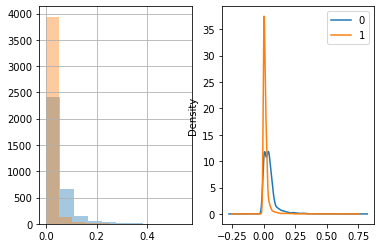

In [183]:
### histogram of TestB groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").TestB.plot(kind='kde', ax=axs[1], legend = True)
data.groupby("treatment").TestB.hist(alpha=0.4, ax=axs[0])

In [184]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["TestB"],data[data["treatment"]==1]["TestB"],alternative="two-sided",usevar="unequal")
pval_list.append(("TestB", pval))
print("P-value : ",pval)


P-value :  2.0497915520390705e-178


## Found that there is significant difference in distribution between two groups

# GeneC

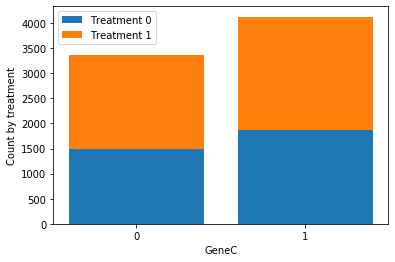

In [185]:
stacked_barplot_btw_columns(data, "treatment", "GeneC", "0", "1")

In [186]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneC"],data[data["treatment"]==1]["GeneC"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneC", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.44655288842904617


In [187]:
linear_model=ols('treatment ~ GeneC', data=data).fit()
print(sm.stats.anova_lm(linear_model, typ=2))

               sum_sq      df         F    PR(>F)
GeneC        0.143237     1.0  0.579234  0.446637
Residual  1854.158630  7498.0       NaN       NaN


# GeneD

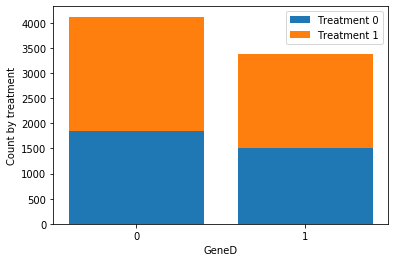

In [188]:
stacked_barplot_btw_columns(data, "treatment", "GeneD", "0", "1")

In [189]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneD"],data[data["treatment"]==1]["GeneD"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneD", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.6410407237875908


In [190]:
linear_model=ols('treatment ~ GeneD', data=data).fit()
print(sm.stats.anova_lm(linear_model, typ=2))

               sum_sq      df         F    PR(>F)
GeneD        0.053751     1.0  0.217354  0.641077
Residual  1854.248115  7498.0       NaN       NaN


# GeneE

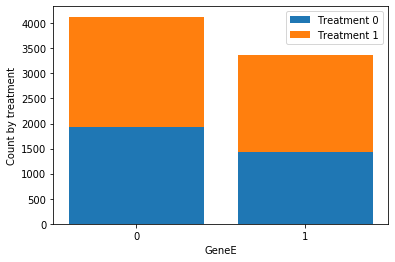

In [191]:
stacked_barplot_btw_columns(data, "treatment", "GeneE", "0", "1")

In [192]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneE"],data[data["treatment"]==1]["GeneE"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneE", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.0001274084269056386


In [193]:
linear_model=ols('treatment ~ GeneE', data=data).fit()
print(sm.stats.anova_lm(linear_model, typ=2))

               sum_sq      df          F    PR(>F)
GeneE        3.620041     1.0  14.666522  0.000129
Residual  1850.681826  7498.0        NaN       NaN


# GeneF

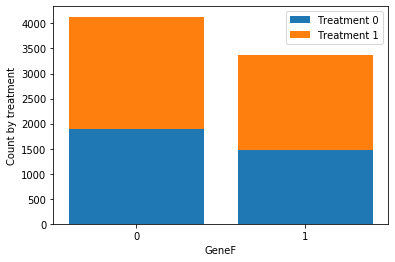

In [194]:
stacked_barplot_btw_columns(data, "treatment", "GeneF", "0", "1")

In [195]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneF"],data[data["treatment"]==1]["GeneF"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneF", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.06728879970716177


In [196]:
linear_model=ols('treatment ~ GeneF', data=data).fit()
print(sm.stats.anova_lm(linear_model, typ=2))

               sum_sq      df         F    PR(>F)
GeneF        0.827077     1.0  3.345836  0.067415
Residual  1853.474790  7498.0       NaN       NaN


In [197]:
p_val = pd.DataFrame(pval_list, columns = ["feature", "p_val"]).sort_values(by = "p_val", ascending = False)
p_val

,feature,p_val
9,GeneD,6.410407e-01
8,GeneC,4.465529e-01
11,GeneF,6.728880e-02
4,blood_test,1.676388e-02
5,Family_History,8.474969e-03
10,GeneE,1.274084e-04
1,blood_pressure,8.566938e-23
2,blood_pressure,8.566938e-23
6,TestA,3.371280e-59
0,age,1.856751e-63


In [198]:
## features that will be removed
p_val[p_val["p_val"]>0.05]

,feature,p_val
9,GeneD,0.641041
8,GeneC,0.446553
11,GeneF,0.067289


## GeneD, GeneE, GeneC are not informative since pvalue of ttest is larger than 0.1
## pvalue of GeneF is larger than 0.05

In [199]:
data.corr()

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
treatment,1.000000,-0.192643,0.112383,-0.457285,-0.027859,0.030165,-0.185840,-0.340274,0.008789,-0.005384,-0.044184,-0.021119
age,-0.192643,1.000000,0.005734,-0.007886,-0.013876,-0.024855,0.969773,-0.012216,-0.006479,0.002007,0.015119,-0.013572
blood_pressure,0.112383,0.005734,1.000000,-0.000068,0.009422,0.009936,0.004832,0.020739,0.004218,0.008333,-0.003862,-0.004004
gender,-0.457285,-0.007886,-0.000068,1.000000,-0.009414,0.007741,-0.009346,0.025504,-0.009414,-0.013633,-0.008340,-0.006969
blood_test,-0.027859,-0.013876,0.009422,-0.009414,1.000000,-0.006826,-0.013463,0.024082,0.024535,-0.016351,0.008870,-0.004918
family_history,0.030165,-0.024855,0.009936,0.007741,-0.006826,1.000000,-0.025380,0.005320,0.024895,0.013234,0.003974,0.001583
TestA,-0.185840,0.969773,0.004832,-0.009346,-0.013463,-0.025380,1.000000,-0.012091,-0.004774,0.004863,0.016239,-0.014315
TestB,-0.340274,-0.012216,0.020739,0.025504,0.024082,0.005320,-0.012091,1.000000,-0.016952,-0.003177,-0.007520,0.003457
GeneC,0.008789,-0.006479,0.004218,-0.009414,0.024535,0.024895,-0.004774,-0.016952,1.000000,0.008430,-0.001292,0.009055
GeneD,-0.005384,0.002007,0.008333,-0.013633,-0.016351,0.013234,0.004863,-0.003177,0.008430,1.000000,0.006305,0.011048


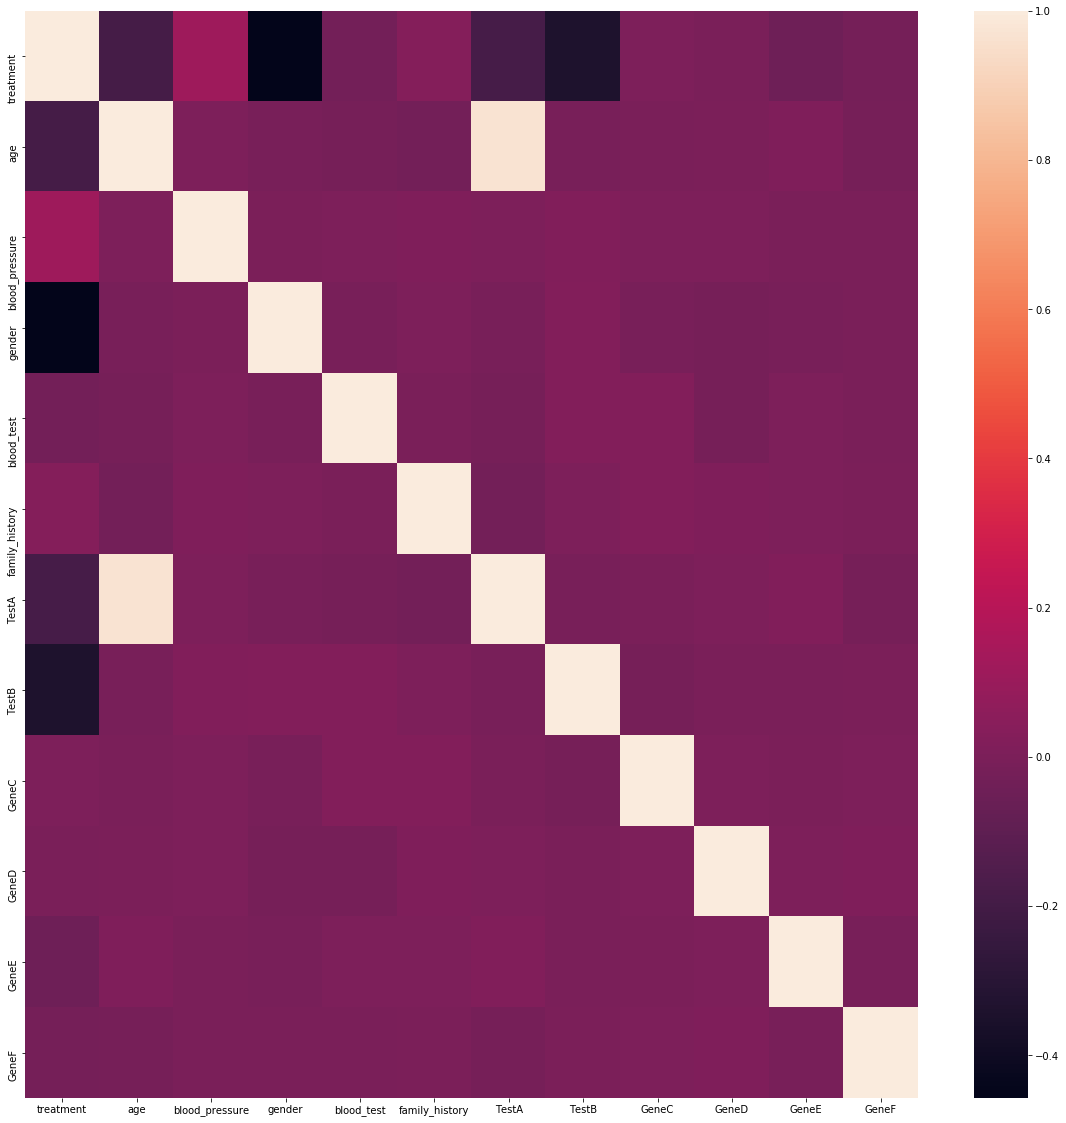

In [200]:
## correlation heatmap of data

f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(data.corr())

#https://seaborn.pydata.org/generated/seaborn.heatmap.html

# train, validation, test split

In [201]:
data

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,64,103.820809,1,0,-1,4.334376,0.105218,0,1,1,0
1,0,52,107.071369,0,0,-1,0.361847,0.045375,1,1,0,0
2,1,55,113.116130,0,1,-1,3.611842,0.005147,0,0,0,1
3,0,45,83.760932,0,0,0,-5.282537,0.056226,1,0,0,0
4,0,58,131.135933,0,0,-1,2.787207,0.038208,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,1,56,99.640132,0,1,-1,2.442280,0.003927,1,0,1,1
7496,1,42,87.712685,0,0,-1,-6.010248,0.011259,0,0,1,0
7497,1,49,95.136721,0,0,0,-0.196411,0.008007,0,1,0,0
7498,1,44,102.552413,0,0,0,-4.116299,0.001477,0,0,0,1


In [202]:
## Split Train, Test data
## allocate predictors to X
X = data.iloc[:,1:]

## allocate test value to y
y = data["treatment"]

## Train, validation, test split applying random state
## Train : Validation : Test = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

## https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [203]:
### use minmax scaler to scale the input features (just for feature importance)

scaler = MinMaxScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# train logistic regression model

In [219]:
logistic = sm.Logit(y_train, X_train).fit()
print(logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.431003
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                 6075
Model:                          Logit   Df Residuals:                     6064
Method:                           MLE   Df Model:                           10
Date:                Sun, 21 Feb 2021   Pseudo R-squ.:                  0.3729
Time:                        19:09:55   Log-Likelihood:                -2618.3
converged:                       True   LL-Null:                       -4175.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age               -0.0051      0.005     -0.978      0.328      -0.015       0.005
blood_pressure   

In [220]:
# print the parameters
clf = LogisticRegression(random_state=0).fit(pd.DataFrame(X_train_scaled).append(pd.DataFrame(X_val_scaled)), y_train.append(y_val))
parameters = pd.DataFrame(clf.coef_.flatten(),X_train.columns,columns=['Parameters'])
parameters["ABS_Parameters"] = parameters["Parameters"].apply(abs)
parameters = parameters.sort_values("ABS_Parameters", ascending = False)
parameters

,Parameters,ABS_Parameters
TestB,-15.665280,15.665280
age,-3.438508,3.438508
gender,-2.528465,2.528465
blood_pressure,2.115568,2.115568
TestA,-1.374972,1.374972
family_history,0.345904,0.345904
blood_test,-0.326797,0.326797
GeneE,-0.272195,0.272195
GeneF,-0.176320,0.176320
GeneD,-0.043306,0.043306


In [221]:
clf = LogisticRegression(random_state=0).fit(X_train.append(X_val), y_train.append(y_val))
y_pred = clf.predict(X_test)

In [222]:
confusion_mat = confusion_matrix(y_test, y_pred)

In [223]:
tn, fp, fn, tp = confusion_mat.ravel()
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [224]:
confusion_mat

array([[243, 102],
       [ 76, 329]])

In [225]:
f1 = tp/(tp+0.5*(fp+fn))

precision = tp/(tp+fp)

accuracy = (tp+tn)/(tp+tn+fn+fp)


In [226]:
print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)
print("False postitive : ", fp)
print("False negative : ", fn)

F1 Score  :  0.7870813397129187
Precision :  0.7633410672853829
Accuracy  :  0.7626666666666667
False postitive :  102
False negative :  76


In [227]:
yhat = clf.predict_proba(X_test)

pos_probs = yhat[:, 1]

print('roc_auc score : ', roc_auc_score(y_test, pos_probs))

roc_auc score :  0.8610127035247808


# L1 regularization

In [215]:
clf = LogisticRegression(penalty='l1',  solver='liblinear')

coefs_ = []
best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
param_list = []

parameters = np.arange(1,100,1)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    confusion_mat = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    auc_list.append(accuracy)
    param_list.append(param)
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_param = param
print("best parameter : ",best_param)
print("Accuracy : ", best_accuracy)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

best parameter :  10
Accuracy :  0.8044444444444444


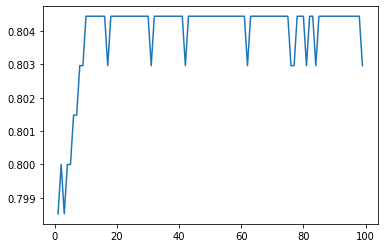

In [228]:
plt.plot(param_list, auc_list)

In [229]:
clf = LogisticRegression(penalty='l1',  solver='liblinear')


best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
f1_list = []
precision_list = []
param_list = []

parameters = np.arange(9,11,0.01)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    confusion_mat = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    
    f1 = tp/(tp+0.5*(fp+fn))
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    
    auc_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    param_list.append(param)
    
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_auc_param = param
        
    if f1>best_f1:
        best_f1 = f1
        best_f1param = param
        
    if precision>best_precision:
        best_precision = precision
        best_precision_param = param
     

In [230]:
print("best auc parameter : ",best_auc_param)
print("Accuracy : ", best_accuracy)
print()
print("best f1 parameter : ",best_f1param)
print("F1 : ", best_f1)
print()
print("best precisioin parameter : ",best_precision_param)
print("Precision : ", best_precision)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

best auc parameter :  9.319999999999993
Accuracy :  0.8044444444444444

best f1 parameter :  9.319999999999993
F1 :  0.8221024258760108

best precisioin parameter :  9.319999999999993
Precision :  0.8243243243243243


Text(0, 0.5, 'AUC')

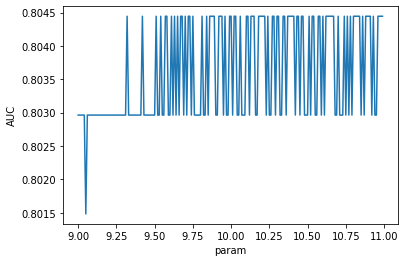

In [231]:
plt.plot(param_list, auc_list)
plt.xlabel("param")
plt.ylabel("AUC")

Text(0, 0.5, 'F1 Score')

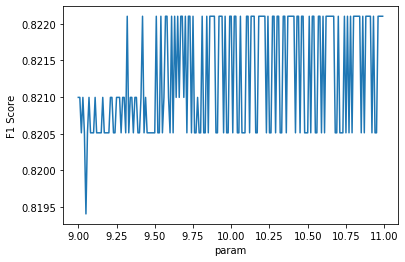

In [232]:
plt.plot(param_list, f1_list)
plt.xlabel("param")
plt.ylabel("F1 Score")

Text(0, 0.5, 'Precision')

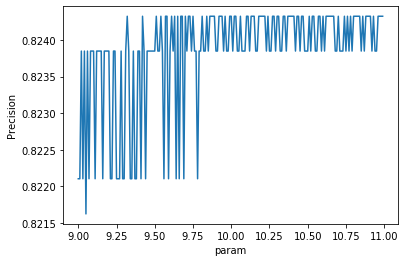

In [233]:
plt.plot(param_list, precision_list)
plt.xlabel("param")
plt.ylabel("Precision")

# Logistic regression with l1 regularization without feature drop

In [251]:
clf = LogisticRegression(penalty='l1',  solver='liblinear')
clf.set_params(C=9.32)
clf.fit(X_train.append(X_val), y_train.append(y_val))
y_pred = clf.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_mat.ravel()

f1 = tp/(tp+0.5*(fp+fn))
precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fn+fp)

In [252]:
print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)
print("False postitive : ", fp)
print("False negative : ", fn)

F1 Score  :  0.8220858895705522
Precision :  0.8170731707317073
Accuracy  :  0.8066666666666666
False postitive :  75
False negative :  70


In [253]:
yhat = clf.predict_proba(X_test)

pos_probs = yhat[:, 1]

print('roc_auc score : ', roc_auc_score(y_test, pos_probs))

roc_auc score :  0.8931687242798354


# Feature selected version

In [237]:
data.columns

Index(['treatment', 'age', 'blood_pressure', 'gender', 'blood_test',
       'family_history', 'TestA', 'TestB', 'GeneC', 'GeneD', 'GeneE', 'GeneF'],
      dtype='object')

In [238]:
fselected_data = data[['treatment', 'age', 'blood_pressure', 'gender', 'blood_test','family_history', 'TestB', "GeneE"]]


In [239]:
## Split Train, Test data
## allocate predictors to X
X = fselected_data.iloc[:,1:]

## allocate test value to y
y = fselected_data["treatment"]

## Train, validation, test split applying random state
## Train : Validation : Test = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

## https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

# Baseline logistic regression

In [240]:
logistic = sm.Logit(y_train, X_train).fit()
print(logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.441067
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                 6075
Model:                          Logit   Df Residuals:                     6068
Method:                           MLE   Df Model:                            6
Date:                Sun, 21 Feb 2021   Pseudo R-squ.:                  0.3582
Time:                        19:13:19   Log-Likelihood:                -2679.5
converged:                       True   LL-Null:                       -4175.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age               -0.0501      0.003    -15.280      0.000      -0.057      -0.044
blood_pressure   

In [241]:
clf = LogisticRegression(random_state=0).fit(X_train.append(X_val), y_train.append(y_val))

y_pred = clf.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_mat.ravel()
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_mat

f1 = tp/(tp+0.5*(fp+fn))

precision = tp/(tp+fp)

accuracy = (tp+tn)/(tp+tn+fn+fp)

print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)
print("False postitive : ", fp)
print("False negative : ", fn)

F1 Score  :  0.7933491686460807
Precision :  0.7643020594965675
Accuracy  :  0.768
False postitive :  103
False negative :  71


In [242]:
yhat = clf.predict_proba(X_test)

pos_probs = yhat[:, 1]

print('roc_auc score : ', roc_auc_score(y_test, pos_probs))

roc_auc score :  0.8607049561638933


# L1 regularization

In [243]:
clf = LogisticRegression(penalty='l1',  solver='liblinear')

coefs_ = []
best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
param_list = []

parameters = np.arange(1,100,1)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    confusion_mat = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    auc_list.append(accuracy)
    param_list.append(param)
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_param = param
print("best parameter : ",best_param)
print("Accuracy : ", best_accuracy)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

best parameter :  2
Accuracy :  0.802962962962963


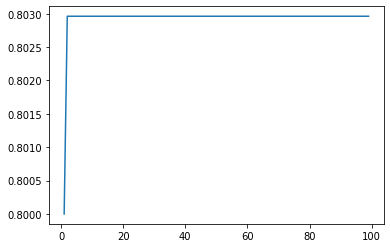

In [244]:
plt.plot(param_list, auc_list)

In [245]:
clf = LogisticRegression(penalty='l1',  solver='liblinear')


best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
f1_list = []
precision_list = []
param_list = []

parameters = np.arange(1,3,0.01)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    confusion_mat = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    
    f1 = tp/(tp+0.5*(fp+fn))
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    
    auc_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    param_list.append(param)
    
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_auc_param = param
        
    if f1>best_f1:
        best_f1 = f1
        best_f1param = param
        
    if precision>best_precision:
        best_precision = precision
        best_precision_param = param
     

In [246]:
print("best auc parameter : ",best_auc_param)
print("Accuracy : ", best_accuracy)
print()
print("best f1 parameter : ",best_f1param)
print("F1 : ", best_f1)
print()
print("best precisioin parameter : ",best_precision_param)
print("Precision : ", best_precision)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

best auc parameter :  1.9600000000000009
Accuracy :  0.8044444444444444

best f1 parameter :  1.9600000000000009
F1 :  0.8206521739130435

best precisioin parameter :  1.9600000000000009
Precision :  0.8296703296703297


Text(0, 0.5, 'AUC')

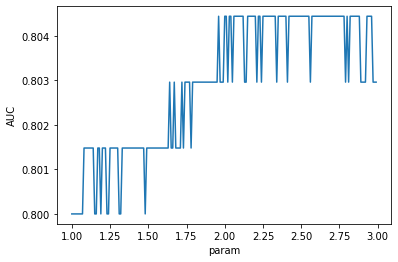

In [247]:
plt.plot(param_list, auc_list)
plt.xlabel("param")
plt.ylabel("AUC")

Text(0, 0.5, 'F1 Score')

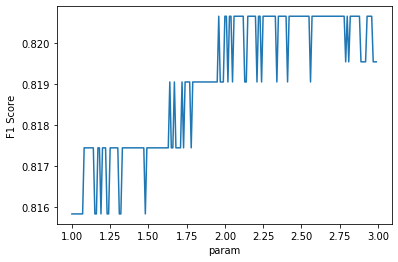

In [248]:
plt.plot(param_list, f1_list)
plt.xlabel("param")
plt.ylabel("F1 Score")

Text(0, 0.5, 'Precision')

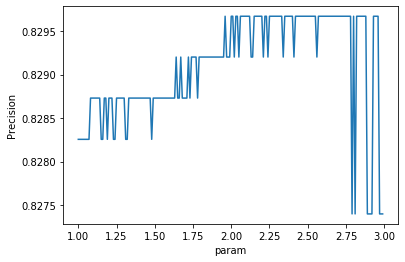

In [249]:
plt.plot(param_list, precision_list)
plt.xlabel("param")
plt.ylabel("Precision")

# final model

In [254]:
clf = LogisticRegression(penalty='l1',  solver='liblinear')
clf.set_params(C=1.96)
clf.fit(X_train.append(X_val), y_train.append(y_val))
y_pred = clf.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_mat.ravel()

f1 = tp/(tp+0.5*(fp+fn))
precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fn+fp)

print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)
print("False postitive : ", fp)
print("False negative : ", fn)

yhat = clf.predict_proba(X_test)

pos_probs = yhat[:, 1]

print('roc_auc score : ', roc_auc_score(y_test, pos_probs))

F1 Score  :  0.8220858895705522
Precision :  0.8170731707317073
Accuracy  :  0.8066666666666666
False postitive :  75
False negative :  70
roc_auc score :  0.8927178386115584
